In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import requests
from io import StringIO

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text), sep=";")

In [3]:
print("Dataset Shape:", data.shape)
print(data.head())

Dataset Shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8      

In [4]:
X = data.drop(columns=["quality"])
y = data["quality"].values

In [5]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
print("Dataset Shape:", data.shape)
print(data.head())

Dataset Shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8      

In [8]:
def add_noise(X, noise_factor=0.05):
    noisy_X = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)
    return np.clip(noisy_X, -3, 3)

In [9]:
X_train_noisy = add_noise(X_train)

In [10]:
def build_model(hidden_layers=[64, 32], learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=l2(0.01)))  # L2 regularization
    model.add(Dropout(dropout_rate))  # Dropout for regularization

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [16]:
for layers in hidden_layer_configs:
    for lr in learning_rates:
        print(f"\nTraining with layers={layers}, learning_rate={lr}")
        model = build_model(hidden_layers=layers, learning_rate=lr)

        # Train the model
        history = model.fit(X_train_noisy, y_train,
                            validation_data=(X_val, y_val),
                            epochs=100,
                            batch_size=32,
                            callbacks=[early_stopping, reduce_lr],
                            verbose=0)


        val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation MAE: {val_mae:.4f}")

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model = model
            best_history = history


Training with layers=[64, 32], learning_rate=0.001
Validation MAE: 0.5597

Training with layers=[64, 32], learning_rate=0.005
Validation MAE: 0.5187

Training with layers=[128, 64, 32], learning_rate=0.001
Validation MAE: 0.5181

Training with layers=[128, 64, 32], learning_rate=0.005
Validation MAE: 0.4975

Training with layers=[256, 128, 64], learning_rate=0.001
Validation MAE: 0.5037

Training with layers=[256, 128, 64], learning_rate=0.005
Validation MAE: 0.5058


In [17]:
y_pred = best_model.predict(X_test).flatten()
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
print(f"\nTest MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Test MAE: 0.4852
Test R² Score: 0.4021


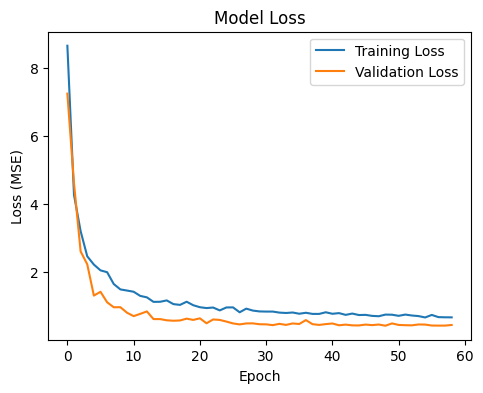

In [18]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

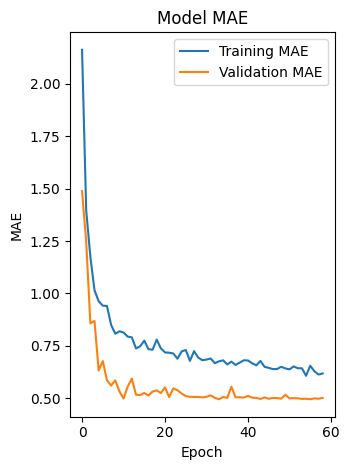

In [19]:
plt.subplot(1, 2, 2)
plt.plot(best_history.history['mae'], label='Training MAE')
plt.plot(best_history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
import math

print("\nSample Predictions:")
for i in range(10):
    print(f"True Quality: {y_test[i]}, Predicted: {round(y_pred[i]):.0f}")


Sample Predictions:
True Quality: 6, Predicted: 6
True Quality: 5, Predicted: 5
True Quality: 7, Predicted: 6
True Quality: 6, Predicted: 6
True Quality: 7, Predicted: 6
True Quality: 7, Predicted: 6
True Quality: 6, Predicted: 6
True Quality: 6, Predicted: 6
True Quality: 5, Predicted: 6
True Quality: 6, Predicted: 7
